# Ex 2 - Transfer learning
##### Group: 2
###### Student 1: Yann Sierro
###### Student 2: Robin Carrupt

In [19]:
import os
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Input
from tensorflow.keras import utils
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import Model
import math

from keras import layers


import tensorflow_datasets as tfds
from sklearn.metrics import accuracy_score

## Load the Dataset and visualize it

In [20]:
# Download and split the food101 dataset
(train_ds, validation_ds, test_ds), info = tfds.load(
    "food101",
    split=["train", "validation[:50%]", "validation[50%:]"],
    as_supervised=True,
    with_info=True
)

In [21]:
# Filter the dataset to keep the first 20 classes only.
N_CLASSES = 20
CLASS_NAMES = info.features['label'].names[:N_CLASSES]

train_ds = train_ds.filter(lambda img, label: label < N_CLASSES)
validation_ds = validation_ds.filter(lambda img, label: label < N_CLASSES)
test_ds = validation_ds.filter(lambda img, label: label < N_CLASSES)

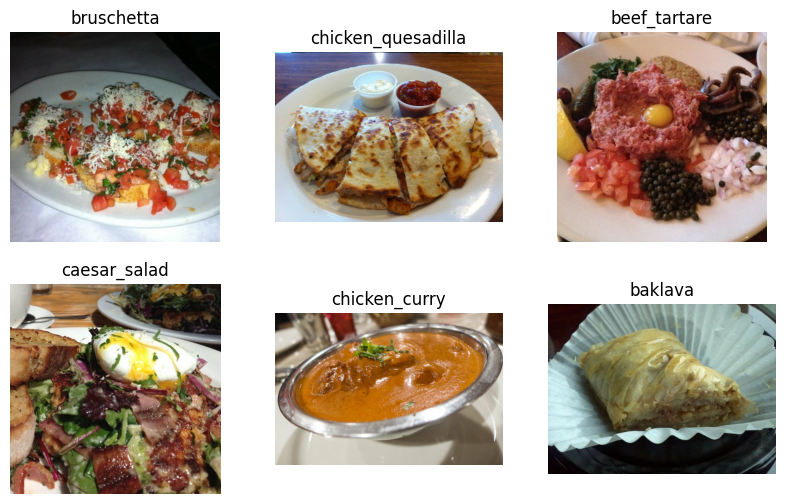

In [22]:
plt.figure(figsize=(10, 6))
for i, (image, label) in enumerate(train_ds.take(6)):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(image)
    plt.title(CLASS_NAMES[label])
    plt.axis("off")

## Resize and normalize

In [23]:
IMG_SIZE = 224
normalisation = tf.keras.Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE, name="resizing"),
    layers.Rescaling(1./127.5, name= "rescaling"),
], name="normalisation")

In [24]:
def resize_img(img):
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    return img

In [25]:
def norm_img(img):
    img = img / 127.5
    return img

In [26]:
def one_hot_encode(x, y):
    one_hot = tf.one_hot(y, depth=N_CLASSES)
    return x, one_hot

## Data-Augmentation

In [27]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical", name="random_flip"),
  layers.RandomRotation(0.8, name="random_rotation"),
], name="data_augmentation")

In [28]:
def augment_img(img):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    return img

## Preparing data

In [29]:
batch_size = 16
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
    # Process the dataset with appropriate batch size and memory management
    ds = ds.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE, IMG_SIZE)), y),
                num_parallel_calls=AUTOTUNE)

    # Normalize images (more memory efficient approach)
    ds = ds.map(lambda x, y: (tf.cast(x, tf.float32) / 127.5, y),
                num_parallel_calls=AUTOTUNE)

    # Convert labels to one-hot
    ds = ds.map(lambda x, y: (x, tf.one_hot(y, depth=N_CLASSES)),
                num_parallel_calls=AUTOTUNE)

    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x), y),
                    num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    # Always batch for memory efficiency
    ds = ds.batch(batch_size)

    # Prefetch for performance
    return ds.prefetch(buffer_size=AUTOTUNE)

In [30]:
da_train_ds = prepare(train_ds, shuffle=True, augment=True)
da_validation_ds = prepare(validation_ds, shuffle=False)
da_test_ds = prepare(test_ds)

# Free up memory
import gc
gc.collect()

# Set memory growth for GPU if using TensorFlow with GPU
try:
    physical_devices = tf.config.list_physical_devices('GPU')
    if physical_devices:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print("No GPU available or could not set memory growth")

No GPU available or could not set memory growth


## Non-functional model

In [31]:
# Define the CNN model
cnn = Sequential()

# First convolutional block
cnn.add(Input(shape=(IMG_SIZE, IMG_SIZE, 3)))  # CIFAR-10 images are 32x32 with 3 color channels
cnn.add(Conv2D(32, (3, 3), padding='same'))
cnn.add(Activation('relu'))
cnn.add(Conv2D(64, (3, 3), padding='same'))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

# Second convolutional block
cnn.add(Conv2D(128, (3, 3), padding='same'))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

# Fully connected layer
cnn.add(Flatten())
cnn.add(Dense(256))
cnn.add(Activation('relu'))
cnn.add(Dense(10))  # 10 classes for CIFAR-10
cnn.add(Activation('softmax'))

cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 401408)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │   102,760,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         2,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,856,522 (392.37 MB)

 Trainable params: 102,856,522 (392.37 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Create callbacks to save memory
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [33]:
epochs = 10

#cnn.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

# Train the model
#log = cnn.fit(
#    da_train_ds,
#    batch_size=batch_size,
#    epochs=epochs,
#    validation_data=da_validation_ds,
#    callbacks=[checkpoint_callback, early_stopping],
#    verbose=1
#)

NameError: name 'log' is not defined

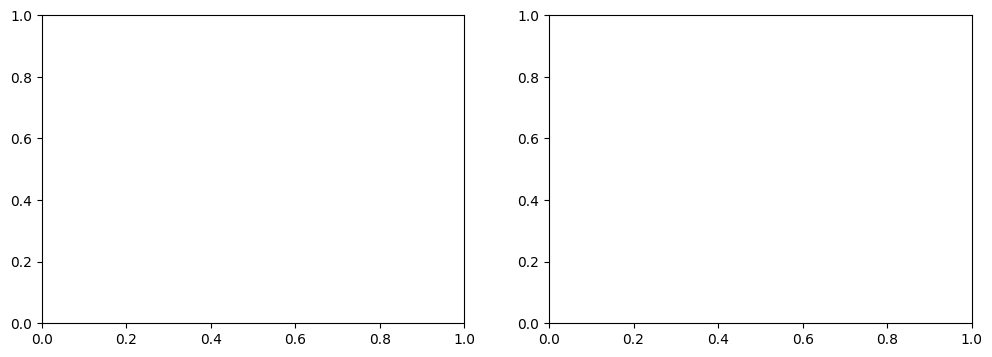

In [34]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log.history['loss'], label='Training loss')
ax1.plot(log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(log.history['accuracy'], label='Training acc')
ax2.plot(log.history['val_accuracy'], label='Testing acc')
ax2.legend()
ax2.grid()

## Training
### Step 1: Only train the head of the network

In [35]:
%%time
# Load the pretrained model from the available models: https://keras.io/api/applications/#available-models.
# Load the imagenet weights but do not include the ImageNet classifier at the top.
#
# Tip, don't choose models that are too big because the training could take hours.
# A model like mobilenet is more than enough for the exercise.

base_model = keras.applications.MobileNet(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights="imagenet",
)

# Freeze the base_model
base_model.trainable = False

# Create the model structure
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

x = base_model(inputs)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(N_CLASSES, activation='softmax')(x)  # Use softmax for multi-class
model = keras.Model(inputs, outputs)

model.summary()

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 20)             │        20,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,249,364 (12.40 MB)

 Trainable params: 20,500 (80.08 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

CPU times: user 1.03 s, sys: 140 ms, total: 1.16 s
Wall time: 1.24 s


In [36]:
epochs = 5
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

# Train the model
log2 = model.fit(
    da_train_ds,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=da_validation_ds,
    callbacks=[checkpoint_callback, early_stopping],
    verbose=1
)

Epoch 1/5
    938/Unknown 199s 192ms/step - accuracy: 0.3145 - loss: 2.3679

938/938 ━━━━━━━━━━━━━━━━━━━━ 218s 213ms/step - accuracy: 0.3146 - loss: 2.3674 - val_accuracy: 0.6241 - val_loss: 1.2359
Epoch 2/5
936/938 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.5460 - loss: 1.5298

938/938 ━━━━━━━━━━━━━━━━━━━━ 206s 206ms/step - accuracy: 0.5460 - loss: 1.5297 - val_accuracy: 0.6619 - val_loss: 1.0856
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.5860 - loss: 1.4011

938/938 ━━━━━━━━━━━━━━━━━━━━ 263s 267ms/step - accuracy: 0.5860 - loss: 1.4011 - val_accuracy: 0.6734 - val_loss: 1.0527
Epoch 4/5
936/938 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.5812 - loss: 1.3831

938/938 ━━━━━━━━━━━━━━━━━━━━ 205s 204ms/step - accuracy: 0.5812 - loss: 1.3831 - val_accuracy: 0.6870 - val_loss: 1.0186
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 261s 205ms/step - accuracy: 0.5986 - loss: 1.3554 - val_accuracy: 0.6802 - val_loss: 1.0344


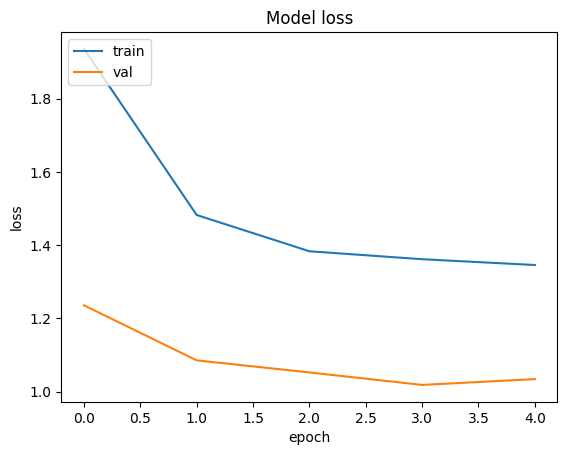

In [37]:
def plot_history(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric])
    plt.title('Model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

plot_history(log2, 'loss')

### Step 2: Fine-Tune the whole model

In [ ]:
%%time


# Unfreeze the pretrained base.
base_model.trainable = True

# Compile the model again
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

epochs = 5

# Retrain the model
log3 = model.fit(
    da_train_ds,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=da_validation_ds,
    callbacks=[checkpoint_callback, early_stopping],
    verbose=1
)

Epoch 1/5
    725/Unknown 232s 219ms/step - accuracy: 0.4516 - loss: 2.0206

In [ ]:
plot_history(log3, 'loss')

## Test the fine-tuned model

In [ ]:
%%time
# Predict the test set
y_pred = model.predict(test_ds, verbose=1)

# De-encode the onehot encoded labels
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for x, y in test_ds], axis=0)

In [ ]:
%%time

# Accuracy
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)

In [ ]:
def show_images_prediction(page=0):
    test_examples = (np.concatenate([x.numpy() for x, y in test_ds])+1)/2*255
    test_examples = test_examples.astype("uint32")

    page_size = 20
    nrows = 4
    ncols = 5
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))
    fig.set_size_inches(20, 16)

    start_i = page * page_size
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(test_examples[i+start_i])
        ax.set_axis_off()
        ax.set_title("Pred: "+CLASS_NAMES[y_pred[i+start_i]]+"\nTrue: "+CLASS_NAMES[y_true[i+start_i]])
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])

    plt.show()
show_images_prediction(2)